## Training a CNN with a Pixel Attribution Prior
This notebook trains a simple convolutional neural network with a total variation penalty on the pixel-wise attributions. This encourages attributions to be smooth. For comparison, we also train the same model without the attribution prior in `without_prior.ipynb`.

In [1]:
import numpy as np
import pandas as pd
import altair as alt

In [2]:
import tensorflow as tf
import shap

FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('f', None, 'Define to make the jupyter kernel happy.')

In [3]:
import mnist_train

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

`FLAGS.lamb` represents the scaling factor for the attribution prior.

In [5]:
FLAGS.lamb = 5e-11
FLAGS.epochs = 50
save_dir = 'with_prior/'

## Input Pipeline
We use the provided scripts `mnist_model.py` and `mnist_train.py` to define and train the graph. 

In [6]:
cond_input_op, x, y, y_, train_pl, loss, train_step, eg_loss, eg_train, train_eg, accuracy_op, accuracy_update_op, reset_metrics_op, \
    training_iterator, validation_iterator, test_iterator, handle = mnist_train.pipeline()

In [7]:
training_handle   = sess.run(training_iterator.string_handle())
validation_handle = sess.run(validation_iterator.string_handle())
test_handle       = sess.run(test_iterator.string_handle())

In [8]:
validation_total_variances, validation_accuracies, test_accuracy = mnist_train.train(save_dir, sess, cond_input_op, y, train_pl, loss, \
                                                                                     train_step, eg_loss, eg_train, train_eg, accuracy_op, \
                                                                                     accuracy_update_op, reset_metrics_op, \
                                                                                     training_iterator, validation_iterator, test_iterator, handle)

INFO:tensorflow:Restoring parameters from with_prior/riation vald (batch): 607.674011
Test accuracy: 0.995100


## Results
Below, we plot the training curves and the expected gradients pixel attributions for a sample of 5 test images. We can see that the attributions are both meaningful and smooth.

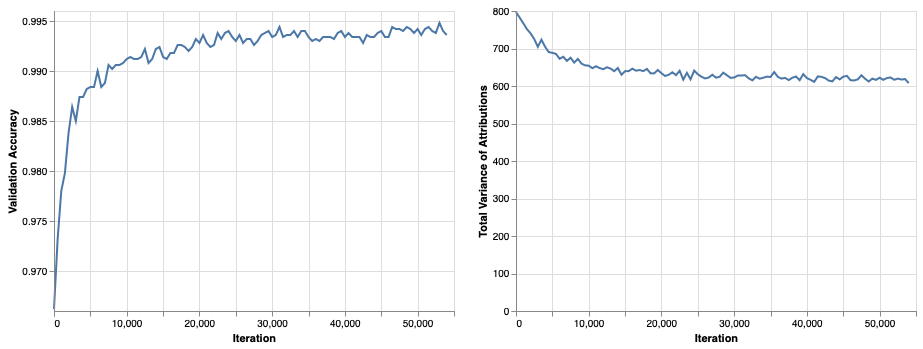

In [9]:
data = pd.DataFrame({
    'Iteration': mnist_train.validation_step * np.arange(len(validation_total_variances[1:])),
    'Total Variance of Attributions': validation_total_variances[1:],
    'Validation Accuracy': validation_accuracies[1:]
})
base = alt.Chart(data).mark_line().encode(
    alt.X('Iteration:Q')
)
base.encode(alt.Y('Validation Accuracy:Q', scale=alt.Scale(zero=False))) | base.encode(alt.Y('Total Variance of Attributions:Q'))

In [10]:
train_data = []
sess.run(training_iterator.initializer)
for i in range(10):
    train_data.append(sess.run(cond_input_op, feed_dict={handle: training_handle}))
train_data = np.concatenate(train_data, axis=0)

sess.run(test_iterator.initializer)
test_data = sess.run(cond_input_op, feed_dict={handle: test_handle})

## Attribution Maps
The plot below shows attribution maps for five test images, for each possible class. Red pixels contribute posivitely to the indicated image being part of the listed class, while blue pixels contribute negatively to the indicated class. For example, the top left image indicates which pixels make the first image (7) look like a 0.

Using TensorFlow backend.


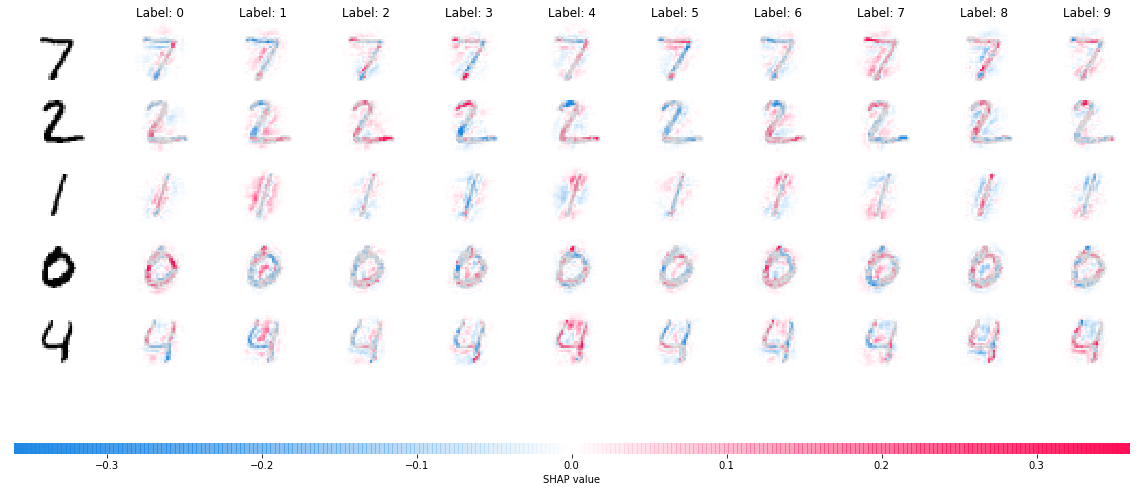

In [11]:
labels = np.array([['Label: {}'.format(i) for i in range(10)]] + [[''] * 10] * 4)
explainer = shap.GradientExplainer((cond_input_op, y), data=train_data, session=sess)
shap_values = explainer.shap_values(test_data[:5])
shap.image_plot(shap_values, -test_data[:5], labels=labels)

## Evaluation on Noise
Here we evaluate the model on noisy test data to simulate a domain shift. That is, we randomly select roughly a fraction of pixels and flip them to be white or black with equal probability. We then re-evaluate our model on the noisy test set. The model trained with an attribution prior is much more robust to noise than the baseline.

In [16]:
def salt_and_pepper(image_pl, minval=0.0, maxval=1.0, percent_flipped=0.1):
    z = 1.0 - (percent_flipped) * 0.5
    t  = tf.distributions.Normal(0.0, 1.0).quantile(z)
    
    random_normal  = tf.random_normal(shape=tf.shape(image_pl))
    clipped_normal = tf.cast(tf.greater(random_normal, t), tf.float32) - \
                     tf.cast(tf.less(random_normal, -t), tf.float32)
    max_range = maxval - minval
    clipped_normal = clipped_normal * max_range
    
    aug_im = image_pl + clipped_normal
    aug_im = tf.clip_by_value(aug_im, 
                              clip_value_min=minval,
                              clip_value_max=maxval)
    return aug_im

In [17]:
noise_level = tf.placeholder(tf.float32, ())
noisy_x = salt_and_pepper(x, minval=-0.5, maxval=0.5, percent_flipped=noise_level)

In [18]:
def get_noise_test_perf(percent_flipped):
    sess.run(reset_metrics_op)
    sess.run(test_iterator.initializer)
    while True:
        try:
            image_batch, label_batch = sess.run([noisy_x, y_], feed_dict={handle: test_handle,
                                                                          noise_level: percent_flipped})
            sess.run(accuracy_update_op, feed_dict={handle: test_handle,
                                                    x: image_batch,
                                                    y_: label_batch})
        except tf.errors.OutOfRangeError:
            break
    test_accuracy = sess.run(accuracy_op)
    return test_accuracy

In [19]:
flip_values = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
noise_perf  = []
for flip_val in flip_values:
    print('Running noise level {}...'.format(flip_val), end='\r')
    noise_perf.append(get_noise_test_perf(flip_val))

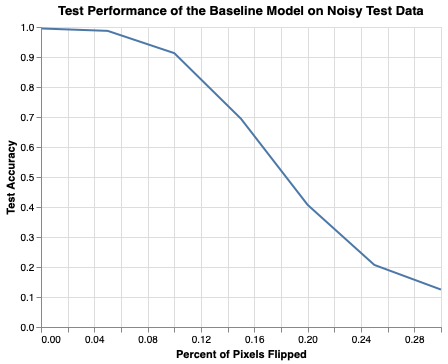

In [20]:
data = pd.DataFrame({'Percent of Pixels Flipped': flip_values, 'Test Accuracy': noise_perf})
alt.Chart(data).mark_line().encode(
    alt.X('Percent of Pixels Flipped:Q'),
    alt.Y('Test Accuracy:Q')
).properties(title='Test Performance of the Baseline Model on Noisy Test Data')

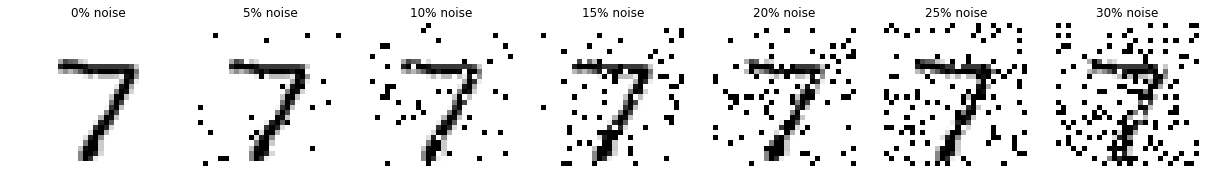

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 7, figsize=(21, 3))

for i in range(7):
    flip_val = flip_values[i]
    sess.run(test_iterator.initializer)
    image_batch = sess.run(noisy_x, feed_dict={handle: test_handle, noise_level: flip_val})
    axs[i].axis('off')
    axs[i].set_title('{}% noise'.format(int(flip_val * 100)))
    axs[i].imshow(-image_batch[0, :, :, 0], cmap='gray')